<a href="https://colab.research.google.com/github/midnight-koffee/weber-law-experiment/blob/main/Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

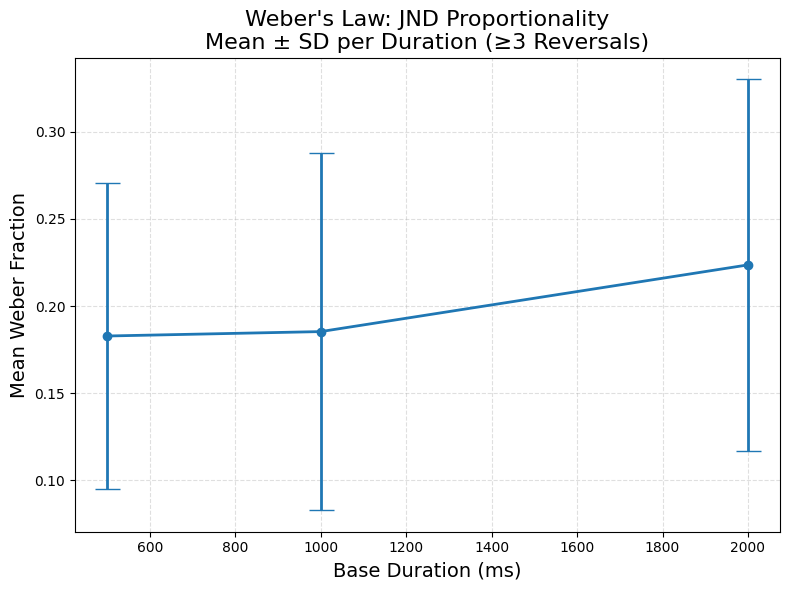

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/weber_final_data.csv')

thresholds = []

for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        # Find reversal trial indices
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })

threshold_df = pd.DataFrame(thresholds)

# Aggregate means and SD for each block (base duration)
summary = threshold_df.groupby('BaseDuration')['WeberFraction'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8,6))
plt.errorbar(summary['BaseDuration'], summary['mean'], yerr=summary['std'],
             fmt='o-', capsize=9, lw=2, color='tab:blue')
plt.xlabel('Base Duration (ms)', fontsize=14)
plt.ylabel('Mean Weber Fraction', fontsize=14)
plt.title("Weber's Law: JND Proportionality\nMean ± SD per Duration (≥3 Reversals)", fontsize=16)
plt.grid(True, alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


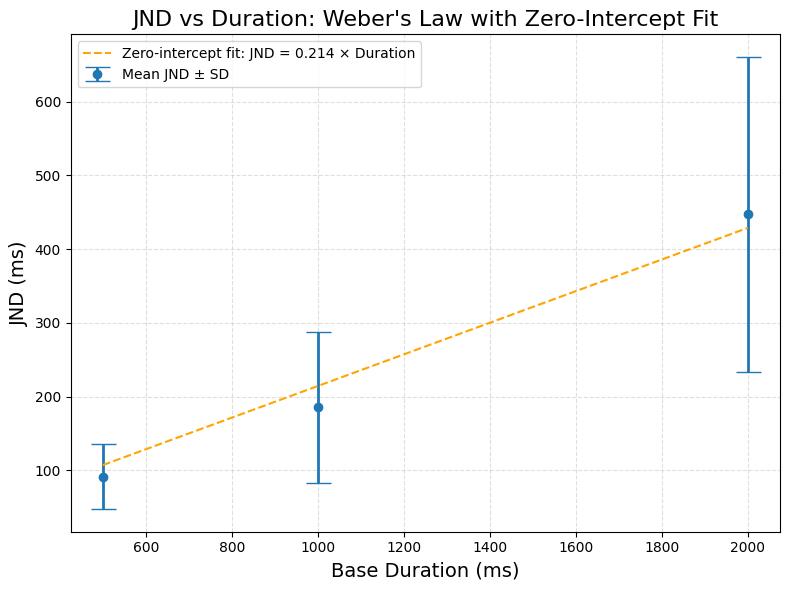

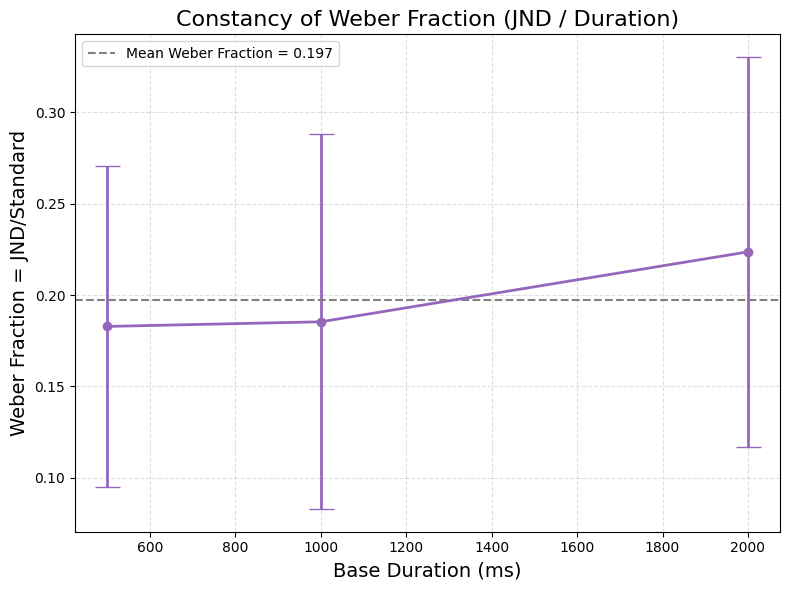

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/weber_final_data.csv')

thresholds = []

for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })

threshold_df = pd.DataFrame(thresholds)

# ---- FIRST PLOT: JND vs Base Duration, fit line through 0 ---- #
summary = threshold_df.groupby('BaseDuration')['WeberFraction'].agg(['mean', 'std']).reset_index()
summary['MeanJND'] = summary['mean'] * summary['BaseDuration']  # JND = mean Weber * base duration

# Fit zero-intercept regression for JND = k * Duration, that is, y = k*x
from numpy.linalg import lstsq
x = summary['BaseDuration'].values.reshape(-1,1)
y = summary['MeanJND'].values
k, _, _, _ = lstsq(x, y, rcond=None)  # Slope only

plt.figure(figsize=(8,6))
plt.errorbar(summary['BaseDuration'], summary['MeanJND'], yerr=summary['std']*summary['BaseDuration'],
             fmt='o', capsize=9, lw=2, color='tab:blue', label="Mean JND ± SD")
plt.plot(summary['BaseDuration'], k*summary['BaseDuration'], '--', color='orange',
         label=f'Zero-intercept fit: JND = {k[0]:.3f} × Duration')
plt.xlabel('Base Duration (ms)', fontsize=14)
plt.ylabel('JND (ms)', fontsize=14)
plt.title("JND vs Duration: Weber's Law with Zero-Intercept Fit", fontsize=16)
plt.grid(True, alpha=0.4, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

# ---- SECOND PLOT: Weber Fraction (JND/Duration) constancy ---- #
plt.figure(figsize=(8,6))
plt.errorbar(summary['BaseDuration'], summary['mean'], yerr=summary['std'],
             fmt='o-', capsize=9, lw=2, color='tab:purple')
plt.axhline(y=np.mean(summary['mean']), color='gray', linestyle='--',
            label=f'Mean Weber Fraction = {np.mean(summary["mean"]):.3f}')
plt.xlabel('Base Duration (ms)', fontsize=14)
plt.ylabel('Weber Fraction = JND/Standard', fontsize=14)
plt.title("Constancy of Weber Fraction (JND / Duration)", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('/content/weber_final_data.csv')

# Compute thresholds for each subject/block (≥3 reversals)
thresholds = []
for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })

threshold_df = pd.DataFrame(thresholds)

print(f"\nNumber of subjects: {threshold_df['ParticipantID'].nunique()}")
print(f"Blocks analyzed: {threshold_df['BaseDuration'].value_counts().to_dict()}")

# Group means per block
group_stats = threshold_df.groupby('BaseDuration')['WeberFraction'].agg(['mean', 'std']).reset_index()
print("\nMean Weber Fractions by Block:")
for _, row in group_stats.iterrows():
    print(f"  {int(row['BaseDuration'])} ms: {row['mean']*100:.2f}%")

# One-way ANOVA for Weber fraction constancy
block_groups = [threshold_df[threshold_df['BaseDuration'] == d]['WeberFraction'].values for d in group_stats['BaseDuration']]
block_f, block_p = stats.f_oneway(*block_groups)
print(f"\nOne-way ANOVA (Weber fraction across durations): F = {block_f:.2f}, p = {block_p:.3f}")

# Group-level regression for k, R2 (fit JND = k * Duration, through origin)
summary = group_stats.copy()
summary['MeanJND'] = summary['mean'] * summary['BaseDuration']
x = summary['BaseDuration'].values
y = summary['MeanJND'].values
k = np.sum(x * y) / np.sum(x * x)
y_pred = k * x
r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
# 95% CI for k
n = len(x)
tval = stats.t.ppf(0.975, n-1)
se = np.sqrt(np.sum((y - k*x)**2) / (n-1)) / np.sqrt(np.sum(x**2))
ci_lower = k - tval * se
ci_upper = k + tval * se
print(f"\nGroup-level regression: k = {k*100:.2f}%")
print(f"95% CI for k: {ci_lower*100:.1f}% – {ci_upper*100:.1f}%")
print(f"R2 = {r2:.3f}")

# Mean accuracy (chance >0.5)
overall_acc = df['Correct'].mean()
print(f"\nMean accuracy across all subjects/blocks: {overall_acc*100:.1f}%")

# ANOVA for individual differences (across subjects)
# Each subject's mean Weber fraction
subject_groups = [threshold_df[threshold_df['ParticipantID'] == p]['WeberFraction'].values for p in threshold_df['ParticipantID'].unique()]
subj_f, subj_p = stats.f_oneway(*subject_groups)
print(f"\nIndividual difference ANOVA: F = {subj_f:.2f}, p = {subj_p:.3f}")

# Reaction time analysis: mean RT for correct vs incorrect, and correlation
mean_rt_corr = df[df['Correct'] == True]['RT'].mean()
mean_rt_err = df[df['Correct'] == False]['RT'].mean()
rt_corr_r, rt_corr_p = stats.pearsonr(df['Correct'].astype(int), df['RT'])
print(f"\nMean RT (correct): {mean_rt_corr:.1f} ms")
print(f"Mean RT (incorrect): {mean_rt_err:.1f} ms")
print(f"RT-accuracy correlation: r = {rt_corr_r:.3f}, p = {rt_corr_p:.3f}")

print("\nIf you paste these results, I will tell you which numbers (percentages, F/p values, k, CI, R^2 etc) you should update in your abstract based on your actual data.")



Number of subjects: 18
Blocks analyzed: {500: 18, 2000: 17, 1000: 16}

Mean Weber Fractions by Block:
  500 ms: 18.28%
  1000 ms: 18.53%
  2000 ms: 22.36%

One-way ANOVA (Weber fraction across durations): F = 0.91, p = 0.410

Group-level regression: k = 21.44%
95% CI for k: 16.4% – 26.5%
R2 = 0.979

Mean accuracy across all subjects/blocks: 84.7%

Individual difference ANOVA: F = 2.35, p = 0.017

Mean RT (correct): 1610.0 ms
Mean RT (incorrect): 3100.4 ms
RT-accuracy correlation: r = -0.129, p = 0.000

If you paste these results, I will tell you which numbers (percentages, F/p values, k, CI, R^2 etc) you should update in your abstract based on your actual data.


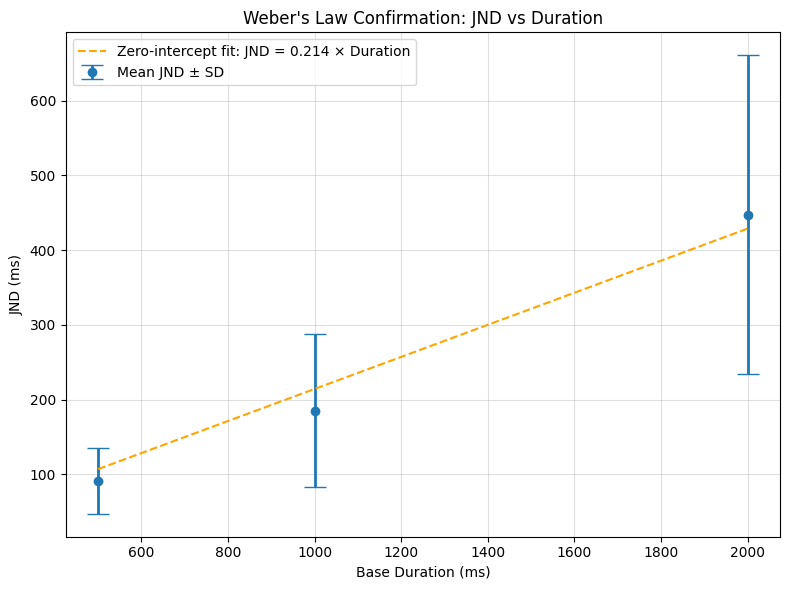

Weber fractions per block: [0.1828 0.1853 0.2236]
One-way ANOVA for constancy: F = 0.91, p = 0.410
Regression slope = 0.214


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numpy.linalg import lstsq

df = pd.read_csv('/content/weber_final_data.csv')

# Threshold estimation (≥3 reversals)
thresholds = []
for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })

threshold_df = pd.DataFrame(thresholds)
summary = threshold_df.groupby('BaseDuration')['WeberFraction'].agg(['mean', 'std']).reset_index()
summary['MeanJND'] = summary['mean'] * summary['BaseDuration']

# Plot mean JND ± SD and fit regression through origin
x = summary['BaseDuration'].values
y = summary['MeanJND'].values
k = np.sum(x * y) / np.sum(x * x)
y_pred = k * x

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=summary['std']*x, fmt='o', capsize=8, lw=2, color='tab:blue', label='Mean JND ± SD')
plt.plot(x, y_pred, '--', color='orange', label=f'Zero-intercept fit: JND = {k:.3f} × Duration')
plt.xlabel('Base Duration (ms)')
plt.ylabel('JND (ms)')
plt.title("Weber's Law Confirmation: JND vs Duration")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# ANOVA: is Weber fraction constant?
block_groups = [threshold_df[threshold_df['BaseDuration'] == dur]['WeberFraction'].values for dur in summary['BaseDuration']]
block_f, block_p = stats.f_oneway(*block_groups)
print(f"Weber fractions per block: {summary['mean'].values.round(4)}")
print(f"One-way ANOVA for constancy: F = {block_f:.2f}, p = {block_p:.3f}")
print(f"Regression slope = {k:.3f}")


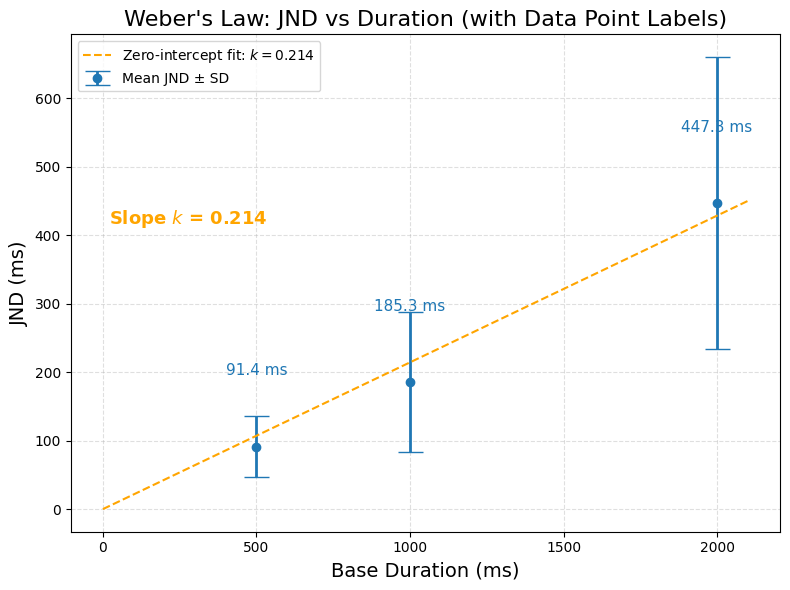

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/weber_final_data.csv')

thresholds = []
for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })

threshold_df = pd.DataFrame(thresholds)
summary = threshold_df.groupby('BaseDuration')['WeberFraction'].agg(['mean', 'std']).reset_index()
summary['MeanJND'] = summary['mean'] * summary['BaseDuration']

# Fit regression through origin
x = summary['BaseDuration'].values
y = summary['MeanJND'].values
k = np.sum(x * y) / np.sum(x * x)

# For a pretty line, extend from zero to slightly past your last duration
xfit = np.linspace(0, x.max() * 1.05, 100)
yfit = k * xfit

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=summary['std']*x, fmt='o', capsize=9, lw=2, color='tab:blue', label='Mean JND ± SD')

plt.plot(xfit, yfit, '--', color='orange', label=f'Zero-intercept fit: $k={k:.3f}$')
for xi, yi in zip(x, y):
    plt.text(xi, yi + 0.05*x.max(), f'{yi:.1f} ms', ha='center', va='bottom', fontsize=11, color='tab:blue')

# Show the slope k in the plot
plt.text(0.01*x.max(), 0.93*y.max(), f"Slope $k$ = {k:.3f}", fontsize=13, color='orange', fontweight='bold')

plt.xlabel('Base Duration (ms)', fontsize=14)
plt.ylabel('JND (ms)', fontsize=14)
plt.title("Weber's Law: JND vs Duration (with Data Point Labels)", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


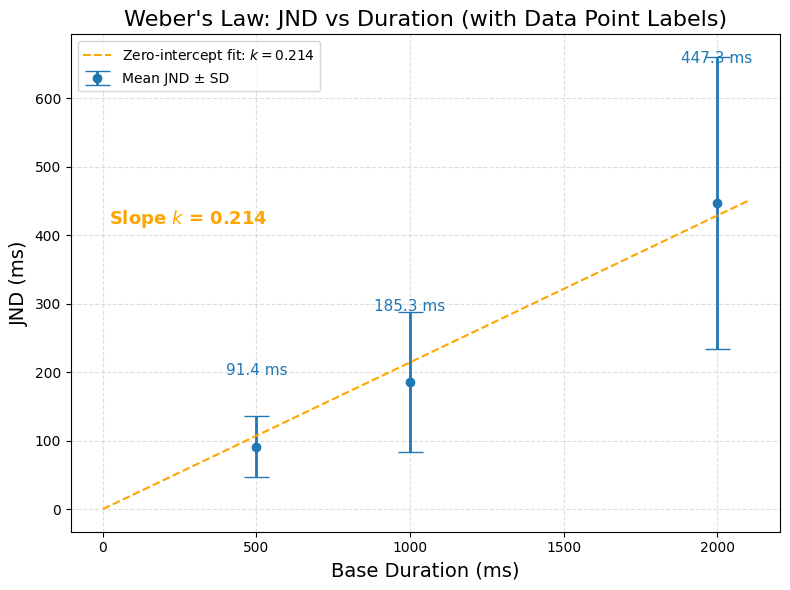

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/weber_final_data.csv')

thresholds = []
for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })

threshold_df = pd.DataFrame(thresholds)
summary = threshold_df.groupby('BaseDuration')['WeberFraction'].agg(['mean', 'std']).reset_index()
summary['MeanJND'] = summary['mean'] * summary['BaseDuration']

# Fit regression through origin
x = summary['BaseDuration'].values
y = summary['MeanJND'].values
k = np.sum(x * y) / np.sum(x * x)

xfit = np.linspace(0, x.max() * 1.05, 100)
yfit = k * xfit

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=summary['std']*x, fmt='o', capsize=9, lw=2, color='tab:blue', label='Mean JND ± SD')
plt.plot(xfit, yfit, '--', color='orange', label=f'Zero-intercept fit: $k={k:.3f}$')

for idx, (xi, yi) in enumerate(zip(x, y)):
    offset = 0.10*x.max() if xi == max(x) else 0.05*x.max()
    plt.text(xi, yi + offset, f'{yi:.1f} ms', ha='center', va='bottom', fontsize=11, color='tab:blue')



plt.text(0.01*x.max(), 0.93*y.max(), f"Slope $k$ = {k:.3f}", fontsize=13, color='orange', fontweight='bold')
plt.xlabel('Base Duration (ms)', fontsize=14)
plt.ylabel('JND (ms)', fontsize=14)
plt.title("Weber's Law: JND vs Duration (with Data Point Labels)", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.4, linestyle="--")
plt.tight_layout()
plt.show()


<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-4024335503.py:32: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Weber Fraction (\%)', fontsize=13)


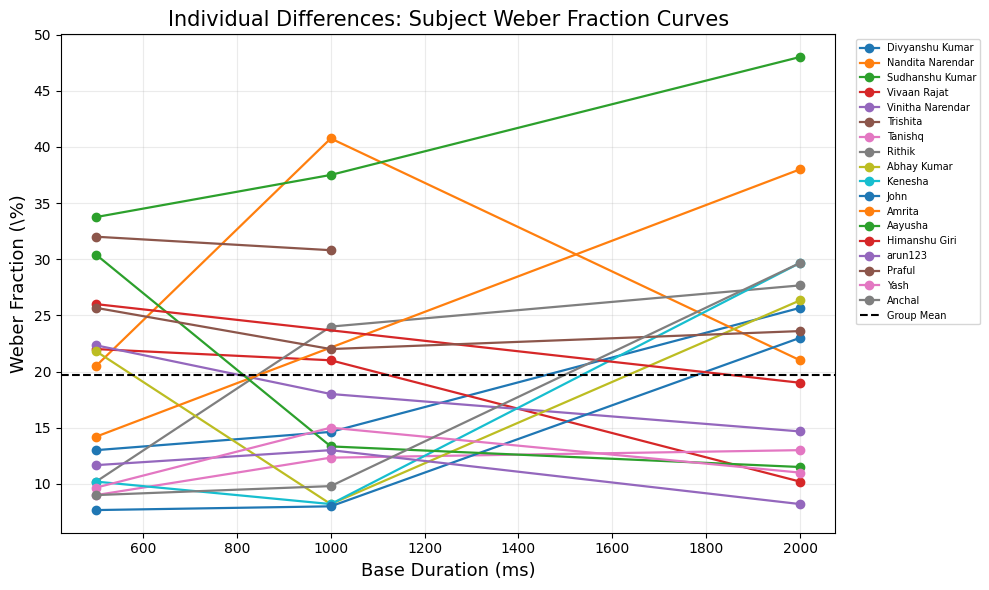

One-way ANOVA (subjects): F = 2.35, p = 0.017


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# (Threshold extraction as in previous section)
df = pd.read_csv('/content/weber_final_data.csv')
thresholds = []
for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })
threshold_df = pd.DataFrame(thresholds)

plt.figure(figsize=(10, 6))
for pid in threshold_df['ParticipantID'].unique():
    pdata = threshold_df[threshold_df['ParticipantID'] == pid].sort_values('BaseDuration')
    plt.plot(pdata['BaseDuration'], pdata['WeberFraction']*100, marker='o', linewidth=1.6, label=pid)
plt.xlabel('Base Duration (ms)', fontsize=13)
plt.ylabel('Weber Fraction (\%)', fontsize=13)
plt.title('Individual Differences: Subject Weber Fraction Curves', fontsize=15)
plt.axhline(y=threshold_df['WeberFraction'].mean()*100, color='k', linestyle='--', label='Group Mean')
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left", fontsize=7)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# ANOVA for statistical test
subject_groups = [threshold_df[threshold_df['ParticipantID'] == p]['WeberFraction'].values for p in threshold_df['ParticipantID'].unique()]
f_stat, p_val = stats.f_oneway(*subject_groups)
print(f"One-way ANOVA (subjects): F = {f_stat:.2f}, p = {p_val:.3f}")


<>:31: SyntaxWarning: invalid escape sequence '\%'
<>:31: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipython-input-2734616054.py:31: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Mean Weber Fraction (\%)')


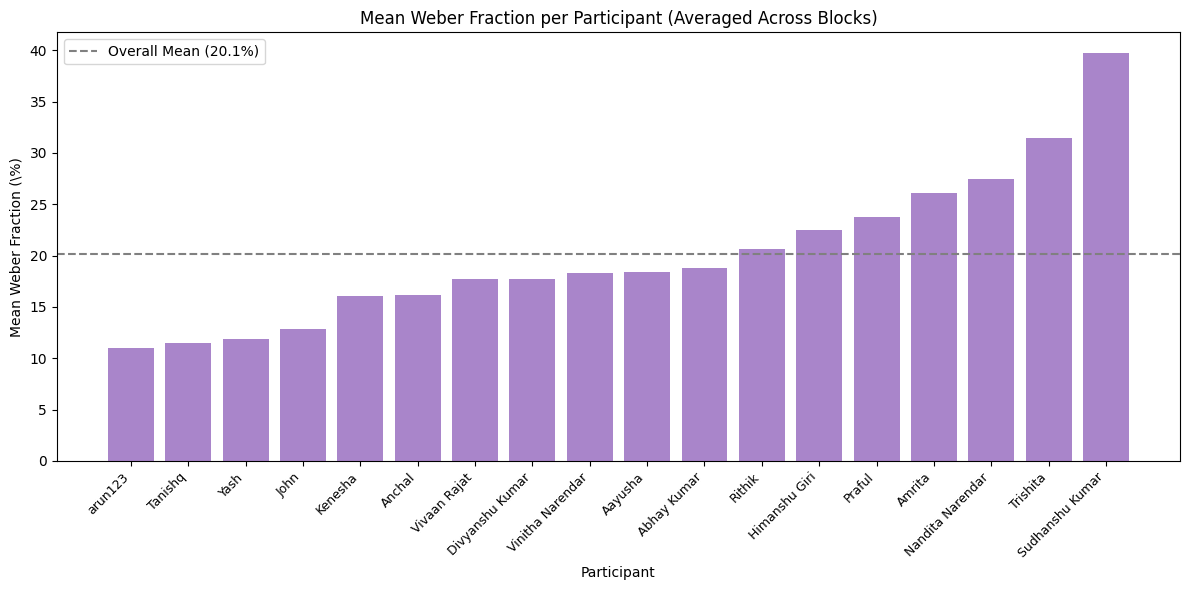

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume thresholds for each subject/block as before
df = pd.read_csv('/content/weber_final_data.csv')
thresholds = []
for pid in df['ParticipantID'].unique():
    pdata = df[df['ParticipantID'] == pid]
    for base_dur in sorted(pdata['BaseDuration'].unique()):
        block = pdata[pdata['BaseDuration'] == base_dur]
        reversals = block['Reversals'].values
        diffs = block['Difference'].values
        rev_trials = [i for i in range(1, len(reversals)) if reversals[i] > reversals[i-1]]
        if len(rev_trials) >= 3:
            last_n = min(len(rev_trials), 8)
            last_reversal_diffs = [diffs[i] for i in rev_trials[-last_n:]]
            mean_weber = np.mean(last_reversal_diffs)
            thresholds.append({
                'ParticipantID': pid,
                'BaseDuration': base_dur,
                'WeberFraction': mean_weber
            })
threshold_df = pd.DataFrame(thresholds)

mean_weber_by_participant = threshold_df.groupby('ParticipantID')['WeberFraction'].mean().sort_values()

plt.figure(figsize=(12,6))
bars = plt.bar(mean_weber_by_participant.index, mean_weber_by_participant.values*100, color='tab:purple', alpha=0.8)
plt.axhline(mean_weber_by_participant.mean()*100, color='gray', linestyle='--', label=f'Overall Mean ({mean_weber_by_participant.mean()*100:.1f}%)')
plt.ylabel('Mean Weber Fraction (\%)')
plt.xlabel('Participant')
plt.title('Mean Weber Fraction per Participant (Averaged Across Blocks)')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.legend()
plt.tight_layout()
plt.show()


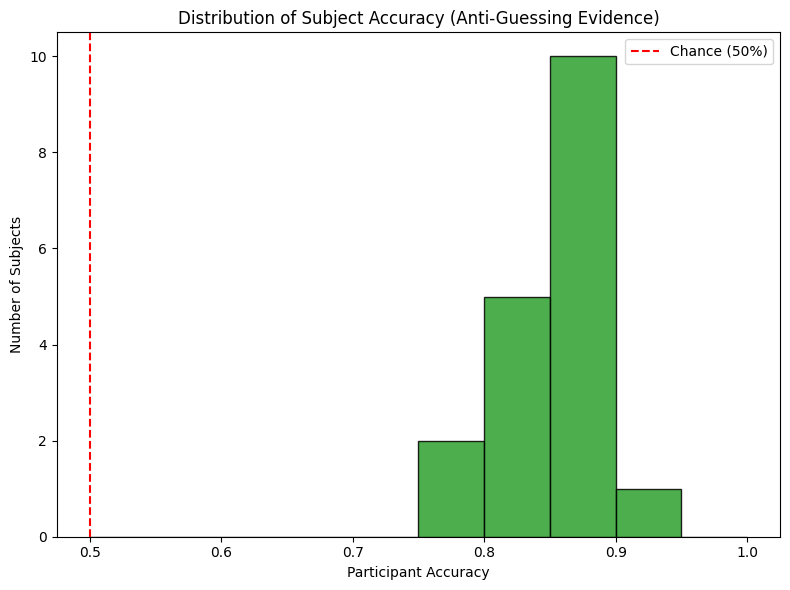

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/content/weber_final_data.csv')

# Calculate participant accuracy
accuracy_by_subject = df.groupby('ParticipantID')['Correct'].mean()

plt.figure(figsize=(8,6))
plt.hist(accuracy_by_subject.values, bins=np.linspace(0.5,1.0,11), color='tab:green', edgecolor='black', alpha=0.85)
plt.axvline(0.5, color='red', linestyle='--', label='Chance (50%)')
plt.xlabel('Participant Accuracy')
plt.ylabel('Number of Subjects')
plt.title('Distribution of Subject Accuracy (Anti-Guessing Evidence)')
plt.legend()
plt.tight_layout()
plt.savefig('resultc.png', dpi=300)
plt.show()


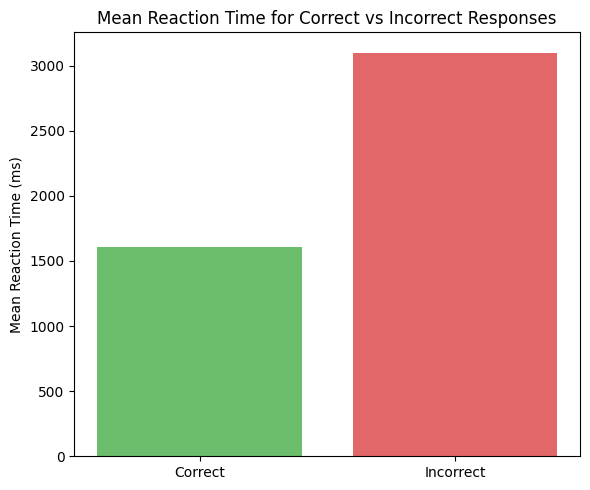

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/weber_final_data.csv')

mean_rt_correct = df[df['Correct'] == True]['RT'].mean()
mean_rt_incorrect = df[df['Correct'] == False]['RT'].mean()

plt.figure(figsize=(6,5))
plt.bar(['Correct', 'Incorrect'], [mean_rt_correct, mean_rt_incorrect], color=['tab:green', 'tab:red'], alpha=0.7)
plt.ylabel('Mean Reaction Time (ms)')
plt.title('Mean Reaction Time for Correct vs Incorrect Responses')
plt.tight_layout()
plt.savefig('resultd.png', dpi=300)
plt.show()
